<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/NDI_ARIMA_Naive_Multi_steps_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

# 1.MULTI-STEPS FORECASTING
This sample follow part 5 of book Deep learning for time series forecasting
predict the Future with CNNs LSTM in Python (Jason Brownlee).
4 model was introduction:
1. naive method
2. autoregression
3. CNN
4. LSTM

Given recent power consumption, what is the expected power consumption for the week ahead?


# 2. BASIC LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_squared_error
from numpy import sqrt
# cho mo hinh arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
# cho CNN model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

# 2. THE ENSENTIAL FUNCTIONS

## 2.1. evaluate one or more weekly forecasts against expected values

In [ ]:
def evaluate_forecasts(actual,predicted):
  scores=list()
  for i in range(actual.shape[1]):
    mse=mean_squared_error(actual[:,i],predicted[:,i])
    rmse=sqrt(mse)
    scores.append(rmse)
  # calculate overall RMSE
  s=0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s+=(actual[row,col]-predicted[row,col])**2
  score=sqrt(s/(actual.shape[0]*actual.shape[1]))
  return score, scores
  # score: sai so trung binh toan bo
  # scores: sai so cua tung buoc

## 2.2 split a univariate dataset into train/test sets
 cac thong so can biet de chia du lieu

 * ti le train/ test
 * so buoc du bao
 * Du lieu phai la n* so buoc du bao

In [ ]:
def split_dataset(data,train_test_ratio,n_output_steps):
  # split into standard weeks
  # boi so cua buoc
  n_pairs_totall=int(data.shape[0]/n_output_steps)
  n_pairs_train=int(train_test_ratio*int(data.shape[0]/n_output_steps))
  n_pairs_test=int(n_pairs_totall-n_pairs_train)
  train, test = data[:-(n_pairs_train*n_output_steps)], data[-(n_pairs_train*n_output_steps):-n_output_steps]
  # restructure into windows of number_steps data
  train = np.array(np.split(train, train.shape[0]/n_output_steps))
  test = np.array(np.split(test, test.shape[0]/n_output_steps))
  return train, test

### 2.2.1 test split functions

In [ ]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
  infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
# dataset.values.shape
train, test = split_dataset(dataset.values,train_test_ratio=0.7,n_output_steps=6) # test/train
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(22, 6, 269)
-0.09606473800000001 0.772332191
(49, 6, 269)
0.59221884 0.355031899


### 2.2.2Walk-forward validation
Input,                   Predict

[Week1]                  Week2

[Week1 + Week2]          Week3

[Week1 + Week2 + Week3]  Week4

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
  s_scores=','.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' %(name, score,s_scores))

## 1.1. Naive methods
* Tomorrow will be the same as today
* Tomorrow will be the same as this day last year
* Tomorrow will an average of last few days

Classical Linear Methods: SARIMA, ETS (triple exponential smoothing)


In [ ]:
# Evaluate a single model
def evaluate_model(model_func,train,test):
  # history is a list of weekly (6months) data
  history=[x for x in train]
  # walk-forward validation over each week
  predictions=list()
  for i in range(test.shape[0]):
    # predict the week
    yhat_sequence=model_func(history)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i,:])
  predictions=np.array(predictions)
  # evaluate predictions day (month) for a weeks (6 months)
  score, scores= evaluate_forecasts(test[:,:,0],predictions)
  return score, scores

### 1.1.1 Daily Persistence Forecast

In [ ]:
# daily persistence model
def daily_persistence(history):
  # get the data for the prior week
  last_week = history[-1]
  # get the total active power for the last day
  value = last_week[-1, 0]
  # prepare 7 day forecast
  forecast = [value for _ in range(7)] # trong baitoan minh sua 7 ngay thanh 6 thang
  return forecast

### 1.1.2 Weekly Persistent Forecast (6 months persistent)

In [ ]:
# weekly persistence model
def weekly_persistence(history):
  # get the data for the prior week
  last_week = history[-1]
  return last_week[:, 0]

### 1.1.3 Weekly One-Year-Ago Persistent Forecast

In [ ]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
  # get the data for the prior week
  last_week = history[-12] # mot nam co 52 tuan, truong hop minh nam co 12 thang
  return last_week[:, 0]

### 1.1.4 Naive Model Comparison

In [ ]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
  infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6) # Thay doi 7 ngay thanh 6 thang

In [ ]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence

daily: [0.724] 0.8,0.7,0.7,0.5,1.0,0.6
weekly: [0.834] 1.0,0.9,1.0,0.5,0.9,0.6
week-oya: [0.933] 1.1,0.6,1.1,0.8,1.0,0.9


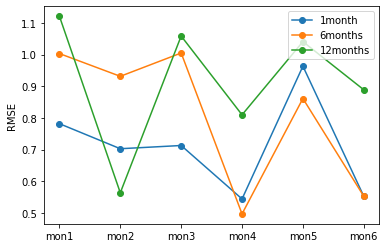

In [ ]:
# evaluate each model
# days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = ['mon1', 'mon2', 'mon3', 'mon4', 'mon5', 'mon6']
for name, func in models.items():
# evaluate and get scores
  score, scores = evaluate_model(func, train, test)
  # summarize scores
  summarize_scores(name, score, scores)
  # plot scores
  plt.plot(days, scores, marker='o', label=name)
  plt.legend(['1month','6months','12months'])
  plt.ylabel('RMSE')

## 1.2 ARIMA MODEL

### 1.2.1 To_series function

In [ ]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
  # extract just the total power from each week
  series = [week[:, 0] for week in data] # week replace by 6 months
  # flatten into a single series
  series = np.array(series).flatten()
  return series

In [ ]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
  infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])

In [ ]:
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6) # change from 7 days to 6 months

In [ ]:
series=to_series(train)

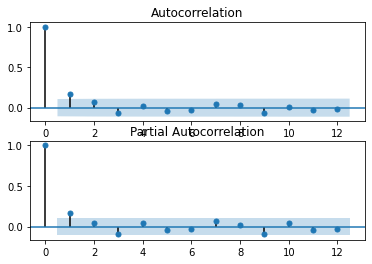

In [ ]:
### Autocorellation plot
# plots
plt.figure()
# lags = 365 # 1 nam 365 ngay, trong bai minh la 12 thang
lags = 12 # 1 nam 365 ngay, trong bai minh la 12 thang
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
plt.show()

### 1.2.2 ARIMA FORECASTING FUNCTION

In [ ]:
# arima forecast
def arima_forecast(history):
  # convert history into a univariate series
  series = to_series(history)
  # define the model
  model = ARIMA(series, order=(6,0,0))
  # fit the model
  model_fit = model.fit(disp=False)
  # make forecast
  yhat = model_fit.predict(series.shape[0],series.shape[0]+5)
  return yhat

### 1.2.3 RESULT FORM ARIMA

arima: [0.626] 0.7,0.6,0.7,0.6,0.6,0.6


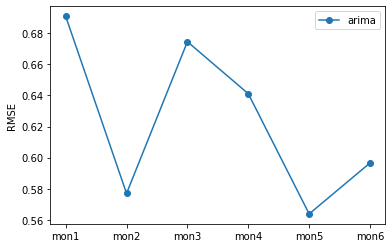

In [ ]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6) # thay 7 ngay thanh 6 thang
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['mon1', 'mon2', 'mon3', 'mon4', 'mon5', 'mon6']
for name, func in models.items():
  # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    plt.plot(days, scores, marker='o', label=name)
# show plot
plt.legend()
plt.ylabel('RMSE')
plt.show()


## 1.3 CNN
* How to develop a CNN for multi-step time series forecasting model for univariate data.
* How to develop a multi-channel multi-step time series forecasting model for multivariate
data.
* How to develop a multi-headed multi-step time series forecasting model for multivariate
data.

### 1.3.1 evaluate a single model

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
  model = build_model(train, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = np.array(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores

# UNIVARIATE CNN MODEL

In [ ]:
# # flatten data
# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

## Covert history into inputs and outputs

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):# change to 6 in outcase
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end:out_end, 0])
    # move along one time step
  in_start += 1
  return np.array(X), np.array(y)

### Train model

In [ ]:
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 20, 4
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = Sequential()
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu',
    input_shape=(n_timesteps,n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

In [ ]:
# # flatten data
# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

In [ ]:
# # retrieve last observations for input data
# input_x = data[-n_input:, 0]

In [ ]:
# # reshape into [1, n_input, 1]
# input_x = input_x.reshape((1, len(input_x), 1))

In [ ]:
# # forecast the next week
# yhat = model.predict(input_x, verbose=0)
# # we only want the vector forecast
# yhat = yhat[0]

In [ ]:
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, 0]
  # reshape into [1, n_input, 1]
  input_x = input_x.reshape((1, len(input_x), 1))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

### CNN test

In [ ]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6) # thay 7 ngay thanh 6 thang

cnn: [0.697] 0.8,0.7,0.6,0.5,0.9,0.7


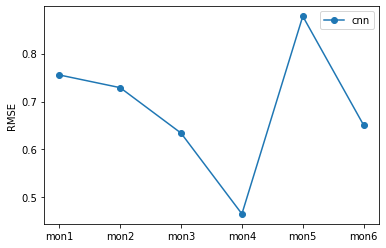

In [ ]:
n_input = 12 # 24 thang tot nhat cho cnn
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['mon1', 'mon2', 'mon3', 'mon4', 'mon5', 'mon6']
plt.plot(days, scores, marker='o', label='cnn')
plt.legend()
plt.ylabel('RMSE')
plt.show()

## MULTI-CHANNEL CNN MODEL

In [ ]:
# # use all variables in input samples
# X.append(data[in_start:in_end, :])

### Covert history into inputs and outputs_multi_channel

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
  # move along one time step
  in_start += 1
  return np.array(X), np.array(y)

In [ ]:
## CHANGE COMPARE WITH UNIVARIATE INPUT
# # retrieve last observations for input data
# input_x = data[-n_input:, :]
# # reshape into [1, n_input, n]
# input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

## FORECATING FUNCTIONS

In [ ]:
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat


###  Training n input function

In [ ]:
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 70, 16
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
    input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

In [ ]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6) # thay 7 ngay thanh 6 thang

cnn: [0.614] 0.7,0.6,0.7,0.5,0.7,0.4


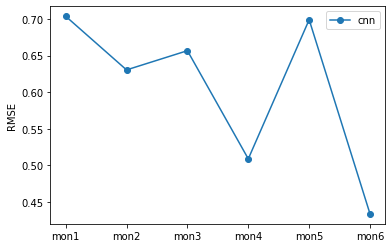

In [ ]:
n_input = 12 # 24 thang tot nhat cho cnn
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['mon1', 'mon2', 'mon3', 'mon4', 'mon5', 'mon6']
plt.plot(days, scores, marker='o', label='cnn')
plt.legend()
plt.ylabel('RMSE')
plt.show()

## Multi-headed CNN Model

In [ ]:
# # create a channel for each variable
# in_layers, out_layers = list(), list()
# for i in range(n_features):
#   inputs = Input(shape=(n_timesteps,1))
#   conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
#   conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
#   pool1 = MaxPooling1D(pool_size=2)(conv2)
#   flat = Flatten()(pool1)
# # store layers
# in_layers.append(inputs)
# out_layers.append(flat)
# # merge heads
# merged = concatenate(out_layers)
# # interpretation
# dense1 = Dense(200, activation='relu')(merged)
# dense2 = Dense(100, activation='relu')(dense1)
# outputs = Dense(n_outputs)(dense2)
# model = Model(inputs=in_layers, outputs=outputs)
# # compile model
# model.compile(loss='mse', optimizer='adam')

In [ ]:
# # define list of input data
# input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]

## Train the model for CNN multi-head

In [ ]:
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 25, 16
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # create a channel for each variable
  in_layers, out_layers = list(), list()
  for i in range(n_features):
    inputs = Input(shape=(n_timesteps,1))
    conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv2)
    flat = Flatten()(pool1)
    # store layers
    in_layers.append(inputs)
    out_layers.append(flat)
  # merge heads
  merged = concatenate(out_layers)
  # interpretation
  dense1 = Dense(200, activation='relu')(merged)
  dense2 = Dense(100, activation='relu')(dense1)
  outputs = Dense(n_outputs)(dense2)
  model = Model(inputs=in_layers, outputs=outputs)
  # compile model
  model.compile(loss='mse', optimizer='adam')
  # plot the model
  plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
  # fit network
  input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in
    range(n_features)]
  model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model


In [ ]:
# # input for making a prediction
# input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]

In [ ]:
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into n input arrays
  input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

In [ ]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6) # thay 7 ngay thanh 6 thang

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.22551 to fit

cnn: [0.795] 0.8,0.9,0.7,0.5,1.0,0.9


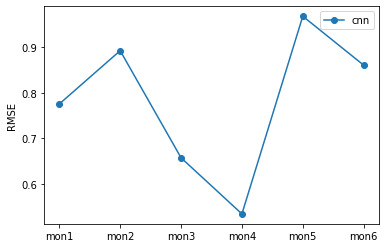

In [ ]:
n_input = 12 # 24 thang tot nhat cho cnn
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['mon1', 'mon2', 'mon3', 'mon4', 'mon5', 'mon6']
plt.plot(days, scores, marker='o', label='cnn')
plt.legend()
plt.ylabel('RMSE')
plt.show()